In [ ]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

Imports


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch
from torch.utils.data import DataLoader

from datasets import Dataset

from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

load dataset

In [ ]:
# Load the data (TSV = tab-separated values)
langs = ['ar', 'bg', 'de', 'en', 'it']
dfs = []

for lang in langs:
    # Use f-string formatting to correctly insert the 'lang' value into the filename
    df = pd.read_csv(f"/content/train_{lang}.tsv", sep="\t")
    df['lang'] = lang
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True)

# # Only drop 'Unnamed: 0' if it exists
# if 'Unnamed: 0' in data.columns:
#     data = data.drop(columns=['Unnamed: 0'])

# # Drop any rows with missing values
# data.dropna(inplace=True)

# Display the dataframe
data

,sentence_id,sentence,label,lang,solved_conflict
0,AlMasryAlYoum_10_1,عندما تولى الرئيس عبد الفتاح السيسى السلطة فى ...,OBJ,ar,NaN
1,MAH_62-curl_01_005,في هذا السياق يشرح عيراني أنّ الخوف لا يقتصر ف...,OBJ,ar,NaN
2,MIS_676-eurl_02_015,وشكك المدير التنفيذي وعميد مجلس المديرين التنف...,OBJ,ar,NaN
3,MIS_2290-curl_03_018,ﻟﻜﻦ ﻟﻸﺳﻒ ﺍﻟﺮﺻﺎﺻﺔ ﻟﻢ ﺗﺼﺐ ﺃﻣﻪ ﻭ ﺍﺳﺘﻘﺮﺕ ﻓﻲ ﺭأﺱ ر...,OBJ,ar,NaN
4,MIS_460-eurl_02_001,الوزارة طالبت بضرورة احترام الإجراءات الوقائية...,OBJ,ar,NaN
...,...,...,...,...,...
6375,0e93f441-9faa-4b64-ad38-690e86b1d0f7,"Presi due della banda, il più piccolo ha 15 anni",OBJ,it,NaN
6376,bdad5c4d-d160-4d8c-9e16-8f26512b8479,Il congresso è previsto tra due anni ma appena...,SUBJ,it,NaN
6377,3e6f5ca0-7cfe-4a3b-96b0-b00af2f9186f,Tutto ciò che fanno nasce da un amore sincero ...,SUBJ,it,NaN
6378,ddae1feb-9fb4-4574-828c-67fe8c3bb063,ha detto il segretario di Stato Usa Antony Bli...,OBJ,it,NaN


In [ ]:
data = data.sample(n=2500, random_state=42).reset_index(drop=True)
data

,sentence_id,sentence,label,lang,solved_conflict
0,a4f13967-76ae-4862-a10f-e220c1db04df,"Беше показано, че всеки плод и всеки зеленчук,...",SUBJ,bg,NaN
1,cac25763-8882-4beb-8b66-efa8cb8e1b05,È auspicabile che la nuova responsabile dello ...,OBJ,it,NaN
2,Almayadeen_32_5,وطبعاً، اللغة تحكم على أن كل الغرب ديمقراطي وك...,SUBJ,ar,NaN
3,AJ_11_18,وعليه، فإنه كلما امتدّت الحرب زمنيًا، ضاقت الخ...,OBJ,ar,NaN
4,cf157f0f-c530-4d1d-b398-32e109faccd0,Per ora si continua a trattare e c'è un pre-ac...,OBJ,it,NaN
...,...,...,...,...,...
2495,MIS_1082-curl_03_070,إليكم 9 أسباب لتورم القدمين وعلاجه: #صحتك_حيات...,OBJ,ar,NaN
2496,MIS_2757-eurl_03_001,عدل البنك الدولي في تقرير نشره الثلاثاء حول تو...,OBJ,ar,NaN
2497,MIS_969-eurl_03_004,وتابع صاحب الـ40 عامًا خلال استضافته عبر برنام...,SUBJ,ar,NaN
2498,e45394ca-65b4-4acc-8906-c90fb151675c,The Conservative manifesto in 2019 was one of ...,SUBJ,en,False


preprocessing

In [ ]:
import re
import nltk
from nltk.corpus import stopwords

# Download necessary NLTK resources
nltk.download('stopwords')

# Manually define Bulgarian stopwords
bulgarian_stopwords = {
    'аз', 'ако', 'ала', 'без', 'беше', 'би', 'бил', 'била', 'били', 'било', 'бих',
    'биха', 'бихме', 'бихте', 'бяха', 'бъдат', 'бъде', 'бъдем', 'бъдете', 'бъдейки', 'бъда',
    'в', 'вас', 'ваш', 'ваша', 'ваше', 'ваши', 'вие', 'във', 'въпреки', 'върху', 'ги', 'го', 'гова',
    'дали', 'да', 'до', 'дори', 'друг', 'друга', 'други', 'друго', 'е', 'евентуално', 'едва', 'едва ли',
    'един', 'една', 'едно', 'едни', 'ето', 'за', 'зад', 'заедно', 'защо', 'защото', 'и', 'из', 'или',
    'им', 'има', 'имат', 'иска', 'искат', 'как', 'какво', 'както', 'като', 'кога', 'когато', 'кой',
    'който', 'която', 'кое', 'кои', 'къде', 'където', 'ли', 'малко', 'ме', 'между', 'мен', 'ми', 'миналия',
    'мина', 'много', 'могат', 'може', 'можеше', 'моето', 'мой', 'моя', 'моята', 'му', 'н', 'на',
    'над', 'най', 'накрая', 'нам', 'нас', 'не', 'него', 'ней', 'нея', 'неща', 'ни', 'ние', 'ним',
    'них', 'но', 'обаче', 'от', 'отгоре', 'относно', 'по', 'под', 'покрай', 'поне', 'поради', 'после',
    'пред', 'преди', 'през', 'при', 'против', 'пък', 'сам', 'сама', 'сами', 'само', 'самата', 'самото',
    'се', 'сега', 'си', 'скоро', 'след', 'сме', 'смях', 'съм', 'със', 'също', 'същият', 'същата', 'същото',
    'съществува', 'та', 'тази', 'така', 'такъв', 'там', 'те', 'теб', 'тебе', 'тези', 'ти', 'това', 'тогава',
    'той', 'толкова', 'този', 'то', 'точно', 'трябва', 'тя', 'тях', 'у', 'хубаво', 'чрез', 'че', 'често',
    'ще', 'щом', 'я'
}

# Map language codes to their stopwords
stopword_map = {
    'ar': set(stopwords.words('arabic')),
    'bg': bulgarian_stopwords,  # use manual stopwords for Bulgarian
    'de': set(stopwords.words('german')),
    'en': set(stopwords.words('english')),
    'it': set(stopwords.words('italian')),
}

# Function to clean a single statement
def clean_statement(statement, lang):
    if not isinstance(statement, str):
        return statement  # In case some value is NaN or not a string

    # Lowercase
    statement = statement.lower()

    # Remove special characters and numbers
    statement = re.sub(r'[^\w\s]', '', statement)
    statement = re.sub(r'\d+', '', statement)

    # Tokenize and remove stopwords
    words = statement.split()
    stop_words = stopword_map.get(lang, set())
    words = [word for word in words if word not in stop_words]

    # Rejoin
    return ' '.join(words)

# Apply the cleaning function
data['sentence'] = data.apply(lambda row: clean_statement(row['sentence'], row['lang']), axis=1)

data


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,sentence_id,sentence,label,lang,solved_conflict
0,a4f13967-76ae-4862-a10f-e220c1db04df,показано всеки плод всеки зеленчук които генет...,SUBJ,bg,NaN
1,cac25763-8882-4beb-8b66-efa8cb8e1b05,auspicabile nuova responsabile iom litaliana l...,OBJ,it,NaN
2,Almayadeen_32_5,وطبعا اللغة تحكم الغرب ديمقراطي وكل الشرق يلوذ...,SUBJ,ar,NaN
3,AJ_11_18,وعليه فإنه امتدت الحرب زمنيا ضاقت الخيارات نتن...,OBJ,ar,NaN
4,cf157f0f-c530-4d1d-b398-32e109faccd0,ora continua trattare cè preaccordo,OBJ,it,NaN
...,...,...,...,...,...
2495,MIS_1082-curl_03_070,أسباب لتورم القدمين وعلاجه صحتك_حياتك يوم معلو...,OBJ,ar,NaN
2496,MIS_2757-eurl_03_001,عدل البنك الدولي تقرير نشره الثلاثاء حول توقعا...,OBJ,ar,NaN
2497,MIS_969-eurl_03_004,وتابع صاحب الـ عاما خلال استضافته عبر برنامج إ...,SUBJ,ar,NaN
2498,e45394ca-65b4-4acc-8906-c90fb151675c,conservative manifesto one least substantial t...,SUBJ,en,False


BALANCE DATASETS

In [ ]:
data['label'].value_counts()

,count
label,
OBJ,1547
SUBJ,953


In [ ]:
from imblearn.over_sampling import RandomOverSampler
import pandas as pd

# Create an instance of RandomOverSampler
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)

# Define features (X) and target (y)
X = data.drop(columns=['label'])  # Change 'status' → 'label'
y = data['label']

# Perform oversampling
X_resampled, y_resampled = ros.fit_resample(X, y)

# Combine the oversampled features and target back into a DataFrame
data = pd.concat([X_resampled, y_resampled], axis=1)

# Check the new class distribution
print(data['label'].value_counts())


label
SUBJ    1547
OBJ     1547
Name: count, dtype: int64


In [ ]:
# Label encoding for 'status' column
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['label'])

In [ ]:
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['sentence'], data['label'], test_size=0.2, random_state=42
)


In [ ]:

max([len(text) for text in data['sentence']])



1345

In [ ]:
from transformers import BertTokenizer

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Tokenize the train and test texts
train_encodings = tokenizer(list(train_texts), padding=True, truncation=True, max_length=200)
test_encodings = tokenizer(list(test_texts), padding=True, truncation=True, max_length=200)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [ ]:
from datasets import Dataset 

# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': train_labels.tolist()
})

test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': test_labels.tolist()
})


In [ ]:
pip install torch


In [ ]:
pip install huggingface_hub[hf_xet]


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 MB 7.9 MB/s eta 0:00:00


In [ ]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels=len(label_encoder.classes_)
)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

import os

# 🚫 Disable W&B logging
os.environ["WANDB_DISABLED"] = "true"

# 🧠 Load model
model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels=len(label_encoder.classes_)
)

# ⚙️ Set training arguments
training_args = TrainingArguments(
    output_dir="./results",              # Output directory for results
    eval_strategy="epoch",               # ✅ updated to avoid deprecation
    save_strategy="epoch",               # Save model at end of each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=7,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    lr_scheduler_type="linear",
    warmup_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=3,
    gradient_accumulation_steps=2
)

# 🏋️ Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# 🚀 Train the model
trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss
1,0.691500,0.679575
2,0.631300,0.629520
3,0.585000,0.616242
4,0.508200,0.565554
5,0.386500,0.583246


Epoch,Training Loss,Validation Loss
1,0.691500,0.679575
2,0.631300,0.629520
3,0.585000,0.616242
4,0.508200,0.565554
5,0.386500,0.583246
6,0.218300,0.766877


TrainOutput(global_step=539, training_loss=0.4698832032853022, metrics={'train_runtime': 34377.2158, 'train_samples_per_second': 0.504, 'train_steps_per_second': 0.016, 'total_flos': 1759760738232000.0, 'train_loss': 0.4698832032853022, 'epoch': 6.916129032258064})

Classification Report:
              precision    recall  f1-score   support

         OBJ       0.73      0.63      0.68       300
        SUBJ       0.69      0.78      0.73       319

    accuracy                           0.71       619
   macro avg       0.71      0.71      0.71       619
weighted avg       0.71      0.71      0.71       619



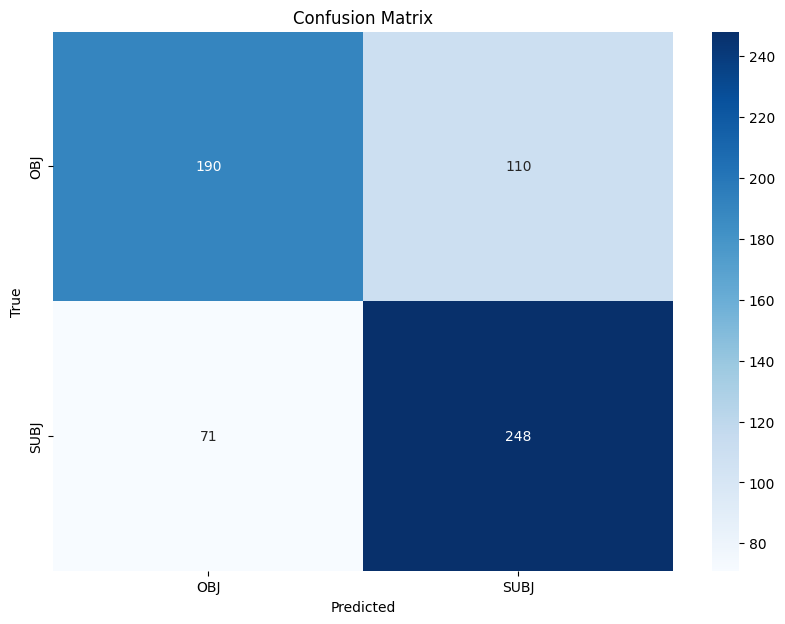

In [ ]:
# 📊 1. Make predictions
predictions, labels, _ = trainer.predict(test_dataset)

# 🎯 2. Convert logits to predicted class labels
predicted_labels = np.argmax(predictions, axis=1)

# 🧾 3. Classification Report
print("Classification Report:")
print(classification_report(test_labels, predicted_labels, target_names=label_encoder.classes_))

# 🔀 4. Confusion Matrix
cm = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# ✅ Save model & tokenizer
trainer.save_model("saved_subjectivity_Classifier_bert")           # Save fine-tuned BERT model
tokenizer.save_pretrained("saved_subjectivity_Classifier_bert")    # Save tokenizer

# ✅ Save LabelEncoder
import pickle
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)


In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import pickle

# Load the model and tokenizer from the saved directory
model = AutoModelForSequenceClassification.from_pretrained("saved_subjectivity_Classifier_bert")
tokenizer = AutoTokenizer.from_pretrained("saved_subjectivity_Classifier_bert")

# Load the LabelEncoder
with open('label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)


In [ ]:
import torch

# 🧼 1. Detection Function
def detect_label(text, lang):
    # Clean the input
    cleaned_text = clean_statement(text, lang)

    # Tokenize the input
    inputs = tokenizer(
        cleaned_text,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=512
    )

    # Run the model
    with torch.no_grad():
        outputs = model(**inputs)

    # Get predicted class
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()

    # Decode predicted label
    return label_encoder.inverse_transform([predicted_class])[0]

# 🧪 2. Sample Texts with Language
sample_texts = [
    ("أشعر أن المدينة أصبحت أكثر ازدحامًا مما كانت عليه.", 'ar'),
    ("تأسست شركة أرامكو السعودية عام 1933.", 'ar'),
    ("بصراحة، أعتقد أن هذا الحي هو الأجمل في الرياض.", 'ar'),
    ("أعلنت الحكومة رفع أسعار الكهرباء بنسبة 10٪.", 'ar'),
    ("في رأيي، يجب تحسين وسائل النقل العام.", 'ar'),
    ("انتهى مشروع توسعة المطار خلال عام 2022.", 'ar'),
    ("أظن أن هذا الفريق لديه فرصة كبيرة للفوز.", 'ar'),
    ("عدد سكان المملكة بلغ 36 مليون نسمة عام 2024.", 'ar'),
    ("أحببت طريقة تقديم المحاضرة بشكل بسيط وواضح.", 'ar'),
    ("هطلت أمطار غزيرة على جدة الأسبوع الماضي.", 'ar'),

    ("Credo che questa sia stata la scelta migliore.", 'it'),
    ("Il museo nazionale è stato fondato nel 1865.", 'it'),
    ("Secondo me, il nuovo ristorante offre piatti deliziosi.", 'it'),
    ("La temperatura a Roma oggi è di 27 gradi.", 'it'),
    ("Penso che dovrebbero migliorare il servizio clienti.", 'it'),
    ("L'azienda ha registrato una crescita del 12% quest'anno.", 'it'),
    ("A mio avviso, il film era troppo lungo e noioso.", 'it'),
    ("Il treno delle 10:00 per Milano è stato cancellato.", 'it'),
    ("Mi sembra che questa decisione sia affrettata.", 'it'),
    ("Il concerto inizia alle 20:30 al teatro centrale.", 'it'),

    ("Мисля, че този проект ще има голям успех.", 'bg'),
    ("Министерството на здравеопазването обяви нова кампания.", 'bg'),
    ("От моя гледна точка, мерките са прекалено строги.", 'bg'),
    ("Температурите ще достигнат 35 градуса тази седмица.", 'bg'),
    ("Вярвам, че можем да постигнем още повече.", 'bg'),
    ("Новият мост ще бъде завършен до края на годината.", 'bg'),
    ("Смятам, че трябва да се инвестира повече в образованието.", 'bg'),
    ("НАСА планира нова мисия към Марс през 2026 година.", 'bg'),
    ("Честно казано, това е най-добрият отбор, който съм виждал.", 'bg'),
    ("България ще бъде домакин на международен форум тази есен.", 'bg'),

    ("I honestly believe this city is the best in the country.", 'en'),
    ("The bridge collapsed during a storm last year.", 'en'),
    ("In my opinion, the new rules are too strict.", 'en'),
    ("The hospital admitted over 300 patients last week.", 'en'),
    ("I feel this movie deserved more awards.", 'en'),
    ("The team won the championship by 5 points.", 'en'),
    ("It's clear to me that the project is a failure.", 'en'),
    ("The company reported a 7% increase in profits.", 'en'),
    ("I absolutely loved the performance last night.", 'en'),
    ("The annual conference will be held in Chicago this year.", 'en'),

    ("Meiner Meinung nach ist dieses Buch wirklich inspirierend.", 'de'),
    ("Das Museum wurde im Jahr 1902 eröffnet.", 'de'),
    ("Ich finde, dass die neuen Regeln unfair sind.", 'de'),
    ("Die Temperaturen erreichten gestern 30 Grad Celsius.", 'de'),
    ("Ich glaube, dass wir mehr in Bildung investieren sollten.", 'de'),
    ("Das Unternehmen eröffnete eine neue Filiale in Hamburg.", 'de'),
    ("Aus meiner Sicht war das Konzert ein voller Erfolg.", 'de'),
    ("Die Bahnstrecke wurde wegen Wartungsarbeiten gesperrt.", 'de'),
    ("Ich denke, der neue Film ist absolut sehenswert.", 'de'),
    ("Die Stadtbibliothek wird im nächsten Monat renoviert.", 'de')
]

# 🔍 3. Run detection
for text, lang in sample_texts:
    predicted_class = detect_label(text, lang)
    print(f"📝 Sentence: {text}\n➡️ Predicted Label: {predicted_class}\n")


📝 Sentence: أشعر أن المدينة أصبحت أكثر ازدحامًا مما كانت عليه.
➡️ Predicted Label: SUBJ

📝 Sentence: تأسست شركة أرامكو السعودية عام 1933.
➡️ Predicted Label: OBJ

📝 Sentence: بصراحة، أعتقد أن هذا الحي هو الأجمل في الرياض.
➡️ Predicted Label: SUBJ

📝 Sentence: أعلنت الحكومة رفع أسعار الكهرباء بنسبة 10٪.
➡️ Predicted Label: OBJ

📝 Sentence: في رأيي، يجب تحسين وسائل النقل العام.
➡️ Predicted Label: SUBJ

📝 Sentence: انتهى مشروع توسعة المطار خلال عام 2022.
➡️ Predicted Label: SUBJ

📝 Sentence: أظن أن هذا الفريق لديه فرصة كبيرة للفوز.
➡️ Predicted Label: SUBJ

📝 Sentence: عدد سكان المملكة بلغ 36 مليون نسمة عام 2024.
➡️ Predicted Label: OBJ

📝 Sentence: أحببت طريقة تقديم المحاضرة بشكل بسيط وواضح.
➡️ Predicted Label: SUBJ

📝 Sentence: هطلت أمطار غزيرة على جدة الأسبوع الماضي.
➡️ Predicted Label: SUBJ

📝 Sentence: Credo che questa sia stata la scelta migliore.
➡️ Predicted Label: SUBJ

📝 Sentence: Il museo nazionale è stato fondato nel 1865.
➡️ Predicted Label: OBJ

📝 Sentence: Secondo me, il n

In [ ]:
import pandas as pd
import torch
import zipfile
# import re
# import nltk
# from nltk.corpus import stopwords

# 🧼 1. Detection Function 



# # Download NLTK stopwords 
# nltk.download('stopwords')

# # Get English stopwords from NLTK
# stop_words = set(stopwords.words('romanian'))

# def clean_statement(statement):
#     # Convert to lowercase
#     statement = statement.lower()

#     # Remove special characters (punctuation, non-alphabetic characters)
#     statement = re.sub(r'[^\w\s]', '', statement)

#     # Remove numbers
#     statement = re.sub(r'\d+', '', statement)

#     # Tokenize and remove stopwords
#     words = statement.split()
#     words = [word for word in words if word not in stop_words]

#     # Rejoin into a cleaned statement
#     cleaned_statement = ' '.join(words)
#     return cleaned_statement

# Apply to the correct column: 'sentence'


def detect_label(text):
    # cleaned_text = clean_statement(text)

    inputs = tokenizer(
        text,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=512
    )

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()

    return label_encoder.inverse_transform([predicted_class])[0]

# 📂 2. Load the input TSV file
input_file = "/content/test_pol_unlabeled.tsv"
df = pd.read_csv(input_file, sep="\t")

assert 'sentence_id' in df.columns and 'sentence' in df.columns, "Input file must have 'sentence_id' and 'sentence' columns"

# 🔍 3. Predict labels and keep alignment
labels = df['sentence'].map(detect_label)  # map() keeps index alignment

# Combine sentence_id + label
output_df = pd.DataFrame({
    'sentence_id': df['sentence_id'],
    'label': labels
})

# 💾 4. Save the TSV output
tsv_output_path = "/content/task1_test_pol.tsv"
output_df.to_csv(tsv_output_path, sep="\t", index=False)

# 🗜️ 5. Zip the TSV file
zip_output_path = "/content/task1_test_pol.zip"
with zipfile.ZipFile(zip_output_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(tsv_output_path, arcname="task1_test_pol.tsv")

print(f"✅ TSV saved to: {tsv_output_path}")
print(f"✅ ZIP file created: {zip_output_path}")

✅ TSV saved to: /content/task1_test_pol.tsv
✅ ZIP file created: /content/task1_test_pol.zip
